# Task 2.2 Custom Training Loop for RF-DETR

RF-DETR, which is a very fast DETR variant, has a very simple training API which only expects the dataset to be structured in a particular way, and the labels in COCO format.

In this notebook, I am bypassing that training API by writing my own training loop and explaining the code in the process.

To make sure that everything can run correctly if you run it on your own machine, let us first install some packages.

In [2]:
%pip install -q rfdetr>=1.4.0 supervision roboflow tqdm torch torchvision matplotlib

Note: you may need to restart the kernel to use updated packages.


In [5]:
category_ids = {
    "traffic sign": 0,
    "traffic light": 1,
    "car": 2,
    "rider": 3,
    "motor": 4,
    "person": 5,
    "bus": 6,
    "truck": 7,
    "bike": 8,
    "train": 9,
}

splits = ["train", "val"]

# Please adjust the below two variables accordingly.
BDD_LABELS_ROOT = "/home/ghosh/assignment/data/bdd100k_labels_release/bdd100k/labels"
BDD_IMAGES_ROOT = "/home/ghosh/assignment/data/bdd100k_images_100k/bdd100k/images/100k"

In [ ]:
import json
from pathlib import Path
from PIL import Image
from typing import Dict, Any


def bdd2coco_detection(
    categories_dict: Dict[str, int], bdd_labels: Any, images_root: str, split: str
) -> None:
    """
    A function that converts the BDD100K labels from
    the JSON file provided in the assignment zip to
    COCO style labels.
    """
    coco = {
        "type": "instances",
        "images": [],
        "annotations": [],
        "categories": [
            {
                "supercategory": "object_supercategory",  # Bypassed a bug to fix this
                "id": v,
                "name": k,
            }
            for k, v in categories_dict.items()
        ],
    }

    annotation_id = 0
    # Map for images to ensure we only add them if they actually exist on disk
    for img_id, obj in enumerate(tqdm(bdd_labels, desc="Converting BDD to COCO")):
        file_name = obj["name"]
        # img_path = Path(images_root) / file_name

        # 1. Skip if the image file doesn't actually exist
        # if not img_path.exists():
        #     continue

        # 2. Get real image dimensions (critical for COCO format)
        # try:
        #     with Image.open(img_path) as img:
        #         w_img, h_img = img.size
        # except Exception:
        #     continue # Skip corrupted images

        w_img, h_img = 1280, 720  # I have verified this for all images in the dataset
        image_entry = {
            "id": img_id,
            "file_name": file_name,
            "width": w_img,
            "height": h_img,
        }

        has_valid_label = False

        for label in obj.get("labels", []):
            # Skip if the category isn't in your 10 classes
            if "box2d" not in label or label["category"] not in categories_dict:
                continue

            # Extract and Validate Coordinates
            x1 = max(0, float(label["box2d"]["x1"]))
            y1 = max(0, float(label["box2d"]["y1"]))
            x2 = min(float(w_img), float(label["box2d"]["x2"]))
            y2 = min(float(h_img), float(label["box2d"]["y2"]))

            # Calculate width and height after clipping
            w_box = x2 - x1
            h_box = y2 - y1

            # Ignore boxes that are too small because
            # DETR models struggle with boxes smaller than 2-4 pixels
            if w_box < 2 or h_box < 2:
                continue

            has_valid_label = True

            coco["annotations"].append(
                {
                    "id": annotation_id,
                    "image_id": img_id,
                    "category_id": categories_dict[label["category"]],
                    "bbox": [float(x1), float(y1), float(w_box), float(h_box)],
                    "area": float(w_box * h_box),
                    "iscrowd": 0,
                }
            )
            annotation_id += 1

        # Only add the image to COCO if it contains at least one valid object
        if has_valid_label:
            coco["images"].append(image_entry)

    # Save Labels
    with open(Path(images_root) / split / "_annotations.coco.json", "w") as f:
        json.dump(coco, f)

    print(
        f"\nSuccessfully saved {len(coco['annotations'])} annotations across {len(coco['images'])} images."
    )

In [8]:
for split in splits:
    # Read the bdd label json and generate coco labels
    bdd_json_path = f"{BDD_LABELS_ROOT}/bdd100k_labels_images_{split}.json"
    with open(bdd_json_path, "r") as f:
        bdd_json = json.load(f)
    bdd2coco_detection(category_ids, bdd_json, BDD_IMAGES_ROOT, split)

Converting BDD to COCO: 100%|██████████| 69863/69863 [00:03<00:00, 21188.57it/s]



Successfully saved 1286487 annotations across 69863 images.


Converting BDD to COCO: 100%|██████████| 10000/10000 [00:00<00:00, 35646.12it/s]



Successfully saved 185473 annotations across 10000 images.


Now that the annotations have been generated, we write our dataloader class

In [9]:
import torch

from torchvision import transforms
import json
from torch.utils.data import Dataset


class CocoDetectionDataset(Dataset):
    def __init__(self, images_dir, annotation_file, transform=None):
        self.images_dir = Path(images_dir)
        self.transform = transform

        with open(annotation_file) as f:
            coco = json.load(f)

        self.images = {img["id"]: img for img in coco["images"]}

        self.annotations = {}
        for ann in coco["annotations"]:
            self.annotations.setdefault(ann["image_id"], []).append(ann)

        self.ids = list(self.images.keys())

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        image_id = self.ids[idx]
        img_info = self.images[image_id]
        image = Image.open(self.images_dir / img_info["file_name"]).convert("RGB")
        w0, h0 = image.size

        # RF-DETR expects image sizes to be a multiple of 32. For faster training,
        # let's use an image size of 320 x 320, which is quite standard for RF-DETR
        image = image.resize((320, 320))
        sx = 320 / w0
        sy = 320 / h0

        annotations = self.annotations.get(image_id, [])
        boxes, labels = [], []
        for annotation in annotations:
            x, y, w, h = annotation["bbox"]
            x1 = x * sx
            y1 = y * sy
            x2 = (x + w) * sx
            y2 = (y + h) * sy
            boxes.append([x1, y1, x2, y2])
            labels.append(annotation["category_id"])

        target = {
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64),
        }

        image = transforms.ToTensor()(image)
        return image, target

This is where we set our device and hyperparameters like learning rate, batch size, gradient accumulation count, and number of epochs.
I ran out of credits to run my notebooks, so I was only able to train for 6 epochs, sorry.

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 10
BATCH_SIZE = 8
EPOCHS = 6
LR = 1e-4
GRAD_ACCUM = 2

Here, we initialize the training dataset with the path to the images, as well as the COCO labels file. Our batch size is 8

In [11]:
from torch.utils.data import DataLoader
from rfdetr.util.misc import collate_fn

transform = transforms.ToTensor()

train_ds = CocoDetectionDataset(
    Path(BDD_IMAGES_ROOT) / "train",
    Path(BDD_IMAGES_ROOT) / "train" / "_annotations.coco.json",
    transform,
)

train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, collate_fn=collate_fn
)

In [ ]:
from rfdetr import RFDETRNano
from rfdetr.models import build_criterion_and_postprocessors
from rfdetr.main import populate_args


# I had to read through the rfdetr.py class on roboflow's website and make some adjustments
wrapper = RFDETRNano(num_classes=NUM_CLASSES)
net = wrapper.model.model
net.to(device)
args = populate_args(num_classes=NUM_CLASSES)
args.segmentation_head = False  # Had to set this to false to prevent errors
# Besides, we are doing object detection, so it makes sense
criterion, _ = build_criterion_and_postprocessors(args)
criterion.to(device)


# Finally, we choose our optimizer. I have chosen Adam, because it is a reliable and popular optimizer which is also used by this model's authors
optimizer = torch.optim.AdamW(net.parameters(), lr=LR, weight_decay=1e-4)

Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 16 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Loading pretrain weights


Reinitializing detection head with 91 classes


### Time to train!

An epoch is one pass over the training data set, and in each pass, we send our images to the model in a minibatch.
In this setup, we have 6 epochs, so our model will see the entire dataset 6 times. We send minibatches of size 8 to the model 8733 times, as our dataset has around 70k images.

In each minibatch pass, the images are "passed through" the model to obtain an output, which is used by the criterion function to generate a loss dict.
This loss dict contains items, for which a weighted average is computed. This is our final loss, and loss.backward() accumulates gradients in our model's parameters.
The optimizer then calls the step method to update the parameters of the model using the accumulated gradients according to the stochastic gradient descent method.

At the end of each epoch, the weights are saved.

In [13]:
from tqdm.auto import tqdm

epoch_losses = []

for epoch in range(EPOCHS):
    net.train()
    criterion.train()

    running_loss = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{EPOCHS}", leave=False)

    for step, (samples, targets) in enumerate(pbar):
        samples = samples.to(device)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        outputs = net(samples)

        loss_dict = criterion(outputs, targets)
        weight_dict = criterion.weight_dict

        loss = sum(loss_dict[k] * weight_dict[k] for k in loss_dict if k in weight_dict)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        avg_loss = running_loss / (step + 1)

        pbar.set_postfix(loss=f"{avg_loss:.4f}")

    epoch_losses.append(avg_loss)

    print(f"Epoch {epoch + 1} | avg loss: {avg_loss:.4f}")
    print(f"Saving checkpoint: {epoch + 1}")
    torch.save(
        net.state_dict(),
        f"/home/ghosh/assignment/trained_models/rfdetr_manual_{epoch + 1}.pth",
    )
    print(f"Sucessfully saved checkpoint for epoch: {epoch + 1}")

Epoch 1/6:   0%|          | 0/8733 [00:00<?, ?it/s]UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)


Epoch 1 | avg loss: 470.6121
Saving checkpoint: 1
Sucessfully saved checkpoint for epoch: 1


Epoch 2 | avg loss: 301.0525
Saving checkpoint: 2
Sucessfully saved checkpoint for epoch: 2


Epoch 3 | avg loss: 261.3895
Saving checkpoint: 3
Sucessfully saved checkpoint for epoch: 3


Epoch 4 | avg loss: 238.1341
Saving checkpoint: 4
Sucessfully saved checkpoint for epoch: 4


Epoch 5 | avg loss: 218.3412
Saving checkpoint: 5
Sucessfully saved checkpoint for epoch: 5


Epoch 6 | avg loss: 202.8431
Saving checkpoint: 6
Sucessfully saved checkpoint for epoch: 6


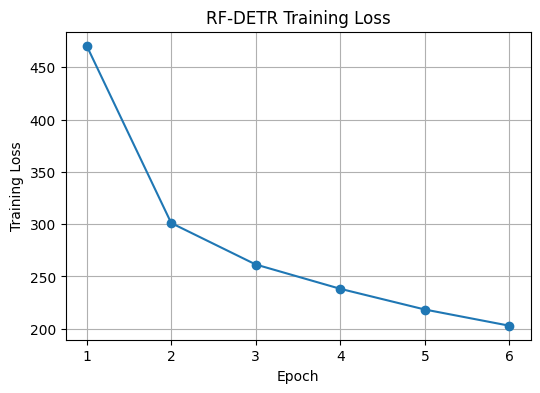

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("RF-DETR Training Loss")
plt.grid(True)
plt.show()

### We have successfully trained our RF-DETR model on the BDD100K train dataset split for 6 epochs. In the next notebook, we will evaluate the model's performance on the val split!.